#  第3章 k近邻法

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from collections import Counter
%matplotlib inline

## KNN

#### 距离度量

**distance**:  
$ L_{p}\left(x_{i}, x_{j}\right)=\left(\sum_{l=1}^{n}\left|x_{i}^{(l)}-x_{j}^{(l)}\right|^{p}\right)^{\frac{1}{p}}$

In [0]:
def distance(x, y, p=2):
    """calculate type of P distance between two points.
    input:
        x: N*M shape array.
        y: 1*M shape array.
        p: type of distance
        
    output:
        N*1 shape of distance between x and y.
    """
    try:
        dis = np.power(np.sum(np.power(np.abs((x - y)), p), 1), 1/p)
    except:
        dis = np.power(np.sum(np.power(np.abs((x - y)), p)), 1/p)
    
    return dis

In [0]:
# load toy data
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['label'] = iris.target
df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']

In [64]:
df.head()

,sepal length,sepal width,petal length,petal width,label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


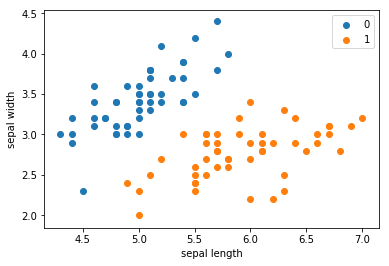

In [65]:
# plot dataset

plt.scatter(df[:50]['sepal length'], df[:50]['sepal width'], label='0')
plt.scatter(df[50:100]['sepal length'], df[50:100]['sepal width'], label='1')
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()

In [0]:
# X, y
data = np.array(df.iloc[:100, [0, 1, -1]])
X, y = data[:,:-1], data[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [0]:
class KNN:
    """
    KNN implementation of violence to calculate.
    """
    def __init__(self, X_train, y_train, n_neighbors=1, p=2):
        """
        n_neighbors: k
                  p: type of distance
        """
        self.k = n_neighbors
        self.p = p
        self.X_train = X_train
        self.y_train = y_train
    
    def predict(self, X):
        diss = distance(self.X_train, X, self.p)
        diss_idx = np.argsort(diss) # return sorted index
        top_k_idx = diss_idx[:self.k]
        top_k_diss = diss[top_k_idx]
        top_k_points = self.X_train[top_k_idx]
        top_k_diss = diss[top_k_idx]
        top_k_y = self.y_train[top_k_idx]
        counter = Counter(top_k_y)
        label = counter.most_common()[0][0]
        return label, top_k_points, top_k_diss
    
    def score(self, X_test, y_test):
        right_count = 0
        for X, y in zip(X_test, y_test):
            label = self.predict(X)[0]
            if label == y:
                right_count += 1
        return right_count / len(X_test)

In [0]:
clf = KNN(X_train, y_train) 

In [69]:
clf.score(X_test, y_test) # test on testset

1.0

In [95]:
# test a single point 

test_point = [6, 2.7]
clf.predict(test_point)

(1.0, array([[6. , 2.7]]), array([0.]))

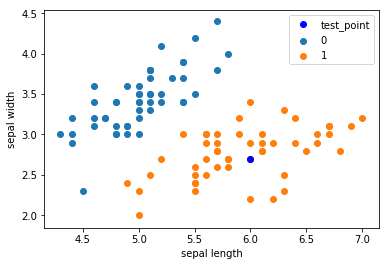

In [96]:
plt.scatter(df[:50]['sepal length'], df[:50]['sepal width'], label='0')
plt.scatter(df[50:100]['sepal length'], df[50:100]['sepal width'], label='1')
plt.plot(test_point[0], test_point[1], 'bo', label='test_point')
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()

#### seems like everything is ok~~~

## scikitlearn

In [0]:
from sklearn.neighbors import KNeighborsClassifier

In [73]:
clf_sk = KNeighborsClassifier()
clf_sk.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [74]:
clf_sk.score(X_test, y_test)

1.0

## kd树

### 构建kd树

In [0]:
# 算法3.2 平衡kd树

class KdTree:
    """
    build kdtree recursively along axis, split on median point.
    k:      k dimensions
    method: alternate/variance, 坐标轴轮替或最大方差轴
    """
    
    def __init__(self, k=2, method='alternate'):
        self.k = k
        self.method = method
        
    def build(self, points, depth=0):
        n = len(points)
        if n <= 0:
            return None
        
        if self.method == 'alternate':
            axis = depth % self.k
        elif self.method == 'variance':
            axis = np.argmax(np.var(points, axis=0), axis=0)
        
        sorted_points = sorted(points, key=lambda point: point[axis])
        
        return {
            'point': sorted_points[n // 2],
            'left': self.build(sorted_points[:n//2], depth+1),
            'right': self.build(sorted_points[n//2+1:], depth+1)
        }

#### 例3.2

In [0]:
data = np.array([[2,3],[5,4],[9,6],[4,7],[8,1],[7,2]])

kd1 = KdTree(k=2, method='alternate')
tree1 = kd1.build(data)

kd2 = KdTree(k=2, method='variance')
tree2 = kd2.build(data)

In [77]:
# friendly print

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(tree1) # equal to figure. 3.4 《统计学习方法》

{   'left': {   'left': {'left': None, 'point': array([2, 3]), 'right': None},
                'point': array([5, 4]),
                'right': {'left': None, 'point': array([4, 7]), 'right': None}},
    'point': array([7, 2]),
    'right': {   'left': {'left': None, 'point': array([8, 1]), 'right': None},
                 'point': array([9, 6]),
                 'right': None}}


In [78]:
pp.pprint(tree2) # 在该数据集上两种方法结果一样

{   'left': {   'left': {'left': None, 'point': array([2, 3]), 'right': None},
                'point': array([5, 4]),
                'right': {'left': None, 'point': array([4, 7]), 'right': None}},
    'point': array([7, 2]),
    'right': {   'left': {'left': None, 'point': array([8, 1]), 'right': None},
                 'point': array([9, 6]),
                 'right': None}}


### 查找kd树

In [0]:
class SearchKdTree:
    """
    search closest point
    """
    def __init__(self, k=2):
        self.k = k
        
    def __closer_distance(self, pivot, p1, p2):
        if p1 is None:
            return p2
        if p2 is None:
            return p1
        
        d1 = distance(pivot, p1)
        d2 = distance(pivot, p2)

        if d1 < d2:
            return p1
        else:
            return p2
    
    def fit(self, root, point, depth=0):
        if root is None:
            return None
        
        axis = depth % self.k
        
        next_branch = None
        opposite_branch = None
        
        if point[axis] < root['point'][axis]:
            next_branch = root['left']
            opposite_branch = root['right']
        else:
            next_branch = root['right']
            opposite_branch = root['left']
            
        best = self.__closer_distance(point,
                                     self.fit(next_branch,
                                             point,
                                             depth+1),
                                     root['point'])
        
        if distance(point, best) > abs(point[axis] - root['point'][axis]):
            best = self.__closer_distance(point,
                                     self.fit(opposite_branch,
                                             point,
                                             depth+1),
                                     best)
            
        return best

In [80]:
# test
point = [3.,4.5]

search = SearchKdTree()
best = search.fit(tree1, point, depth=0)
print(best)

[2 3]


In [81]:
# force computing
def force(points, point):
    dis = np.power(np.sum(np.power(np.abs((points - point)), 2), 1), 1/2)
    idx = np.argmin(dis, axis=0)
    return points[idx]
print(force(data, point))

[2 3]


### test time cost between force and kd-tree

In [0]:
from time import time

In [83]:
# generate sample points
N = 500000
K = 5
points = np.random.randint(15, size=(N, K))
print('points shape:{}'.format(points.shape))

points shape:(500000, 5)


In [0]:
# build tree
kd_tree = KdTree(k=K, method='alternate')
tree = kd_tree.build(points)

In [85]:
# generate test point
#test_point = np.random.randint(10, size=(K))
test_point = [14., 3.5, 10.6, 7.2, 9.2]
print('test point: {}'.format(test_point))

test point: [14.0, 3.5, 10.6, 7.2, 9.2]


In [86]:
#search point

start = time()
seah = SearchKdTree()
best = seah.fit(tree, test_point, depth=0)
end = time()
dist = distance(test_point, best)
print('best point:{}, distance:{}, time cost:{}'.format(best, dist, end - start))

best point:[14  3 11  7  9], distance:0.7000000000000001, time cost:5.568157196044922


In [87]:
# force computing

start = time()
best = force(points, test_point)
end = time()
dist = distance(test_point, best)
print('best point:{}, distance:{}, time cost:{}'.format(best, dist, end - start))

best point:[14  4 11  7  9], distance:0.7000000000000001, time cost:0.09840011596679688


##### 看上去，相比于在大量的数据点中寻找与目标最近的点，kd树不需要一个个查找,O(n)的复杂的，看上去确实效率提高了。但是！对于numpy来说，numpy的矩阵运算是常量时间复杂度O(1)，效率极高。在内存许可的情况下，可以快速查找出符合要求的点, 速度比kd树还快, 从上面的时间消耗可以看出。

#### assignment

In [0]:
### 作业

data = np.array([[5,4], [9,6],[4,7],[2,3],[8,1],[7,2]])
label = np.array([0,0,0,1,1,1])

In [89]:
data

array([[5, 4],
       [9, 6],
       [4, 7],
       [2, 3],
       [8, 1],
       [7, 2]])

In [102]:
label

array([0, 0, 0, 1, 1, 1])

In [90]:
k = KNN(data, label)
k.predict([5,3])

(0, array([[5, 4]]), array([1.]))

In [101]:
distance(data,[5,3])

array([1.        , 5.        , 4.12310563, 3.        , 3.60555128,
       2.23606798])

In [106]:
# sklearn

clf_sk1 = KNeighborsClassifier(n_neighbors=1)
clf_sk1.fit(data, label)

clf_sk1.predict(np.array([5,3]).reshape(-1, 2))

array([0])

## Reference
* 李航 《统计学习方法》  
* https://github.com/fengdu78/lihang-code/blob/master/code/%E7%AC%AC3%E7%AB%A0%20k%E8%BF%91%E9%82%BB%E6%B3%95(KNearestNeighbors)/KNN.ipynb  
* https://www.youtube.com/watch?v=u4M5rRYwRHs&t=449s  
* https://www.youtube.com/watch?v=XqXSGSKc8NU&t=335s  
* https://www.youtube.com/watch?v=DlPrTGbO19E  